In [16]:
import sys
sys.path.append('/home/yeyiqi/Documents/repos/GaussianAvatars')
sys.path.append('/home/yeyiqi/.conda/envs/gaussian-avatars/lib/python3.10/site-packages')

In [17]:
from plyfile import PlyData, PlyElement
from PIL import Image
import numpy as np
import torch
from torch.utils.data import DataLoader
import torch.nn.functional as F
import sys
import os
from pathlib import Path
import pickle
from typing import NamedTuple, Optional
from utils.graphics_utils import ClothMesh, SmplxMesh, ClothedSmplxMesh, read_ply_mesh
from utils.loss_utils import l1_loss, ssim
from scene.cloth_smplx_model import ClothSmplxGaussianModel
from scene.dataset_readers import getNerfppNorm
from gaussian_renderer import render
from tqdm import tqdm
from utils.graphics_utils import getWorld2View2, getProjectionMatrix
from simple_knn._C import distCUDA2

In [18]:
class CustomArgs(NamedTuple):
    upper_path = '/home/yeyiqi/Documents/WD/00129/Outer/Take7/Semantic/clothes/cloth-f00016_upper.ply'
    outer_path = '/home/yeyiqi/Documents/WD/00129/Outer/Take7/Semantic/clothes/cloth-f00016_outer.ply'
    lower_path = '/home/yeyiqi/Documents/WD/00129/Outer/Take7/Semantic/clothes/cloth-f00016_lower.ply'
    shoe_path = '/home/yeyiqi/Documents/WD/00129/Outer/Take7/Semantic/clothes/cloth-f00016_shoe.ply'
    smplx_path = '/home/yeyiqi/Documents/WD/00129/Outer/Take7/SMPLX/mesh-f00016_smplx.ply'
    cam_path = '/home/yeyiqi/Documents/WD/00129/Outer/Take7/Capture/cameras.pkl'
    frame = '00016'
    model_path = '/home/yeyiqi/Documents/WD/00129/Outer/Take7/Capture'
    resolution = 1
    iterations = 10000  # 30_000 (original)
    position_lr_init = 0.00016  # (scaled up according to mean triangle scale)  #0.00016 (original)
    position_lr_final = 0.0000016  # (scaled up according to mean triangle scale) # 0.0000016 (original)
    position_lr_delay_mult = 0.01
    position_lr_max_steps = 30000  # 30_000 (original)
    feature_lr = 0.0025
    opacity_lr = 0.05
    scaling_lr = 0.005  # (scaled up according to mean triangle scale)  # 0.005 (original)
    rotation_lr = 0.001
    densification_interval = 100  # 100 (original)
    opacity_reset_interval = 1000 # 3000 (original)
    densify_from_iter = 500  # 500 (original)
    densify_until_iter = 6000  # 15_000 (original)
    densify_grad_threshold = 0.0002
    flame_expr_lr = 1e-3
    flame_trans_lr = 1e-6
    flame_pose_lr = 1e-5
    percent_dense = 0.01
    lambda_dssim = 0.2
    lambda_xyz = 1e-2
    threshold_xyz = 1.
    metric_xyz = False
    lambda_scale = 1.
    threshold_scale = 0.6
    metric_scale = False
    lambda_dynamic_offset = 0.
    lambda_laplacian = 0.
    lambda_dynamic_offset_std = 0  #1.
    # pipe parameters
    convert_SHs_python = False
    compute_cov3D_python = False
    debug = False
    data_device = 'cuda'
    save_iterations = [1,100,1000,5000,10000]

In [19]:
args = CustomArgs()
upper_mesh = read_ply_mesh(args.upper_path)
outer_mesh = read_ply_mesh(args.outer_path)
lower_mesh = read_ply_mesh(args.lower_path)
shoe_mesh = read_ply_mesh(args.shoe_path)
smplx_mesh = read_ply_mesh(args.smplx_path, type='smplx')


In [20]:
meshes = [outer_mesh, upper_mesh, lower_mesh, shoe_mesh, smplx_mesh]

In [21]:
class CameraInfo(NamedTuple):
    uid: int
    R: np.array
    T: np.array
    id: int
    FoVy: np.array
    FoVx: np.array
    normed_image: Optional[np.array]
    image_path: str
    image_name: str
    image_width: int
    image_height: int
    bg: np.array = np.array([0, 0, 0])
    

class SceneInfo(NamedTuple):
    train_cameras: list
    nerf_normalization: dict
    test_cameras: Optional[list] = None
    ply_path: Optional[str] = None

def readCamerasfrom4DDress(path, frame:str, bg:np.array, extension=".png"):
    cam_infos = []
    path = Path(path)
    with open(path, 'rb') as file:
        contents = pickle.load(file)
    path_related = path.parent
    for folder, in_extri in contents.items():
        id = 1
        img_path = path_related/folder/'images'/f'capture-f{frame}{extension}'
        mask_path = path_related/folder/'masks'/f'mask-f{frame}{extension}'
        img_name = img_path.name
        w2c = in_extri['extrinsics']
        R = np.transpose(w2c[:3,:3])
        T = w2c[:3, 3]
        # bg = np.array([1.0, 1.0, 1.0]) if white_background else np.array([0.0,0.0,0.0])
        image = Image.open(img_path)
        im_data = np.array(image.convert("RGBA"))
        norm_data = im_data / 255.0
        mask = np.array(Image.open(mask_path))
        binary_mask = mask == 255
        norm_data[~binary_mask, -1] = 0
        arr = norm_data[:,:,:3] * norm_data[:, :, 3:4] + bg * (1 - norm_data[:, :, 3:4])
        image = arr
        height, width, _= image.shape
        intri = in_extri['intrinsics']
        fx, fy = intri[0, 0], intri[1, 1]
        fovx = 2 * np.arctan(width / (2 * fx))
        fovy = 2 * np.arctan(height / (2 * fy))

        cam_infos.append(CameraInfo(
            uid=int(folder),
            R=R,
            T=T,
            FoVy=fovy,
            FoVx=fovx,
            bg=bg,
            normed_image=image,
            image_path=img_path,
            image_name=img_name,
            image_width=width,
            image_height=height,
            id = id
        ))
        id += 1
    return cam_infos

def readStaticGaussianInfo(cam_infos):
    train_cam_infos = cam_infos
    nerf_normalization = getNerfppNorm(train_cam_infos)
    scene_info = SceneInfo(
        train_cameras = train_cam_infos,
        nerf_normalization = nerf_normalization
    )
    return scene_info

In [22]:
class Camera(torch.nn.Module):
    def __init__(self, R, T, FoVx, FoVy, image_width, image, image_height, image_path,
                 image_name, uid, bg=np.array([0.0, 0.0, 0.0]), trans=np.array([0.0, 0.0, 0.0]), scale=1.0,
                 timestep=None, data_device = "cuda"
                 ):
        super(Camera, self).__init__()

        self.uid = uid
        self.R = R
        self.T = T
        self.FoVx = FoVx
        self.FoVy = FoVy
        self.bg = bg
        self.image = image
        self.image_width = image_width
        self.image_height = image_height
        self.image_path = image_path
        self.image_name = image_name
        self.original_image = self.image

        self.zfar = 100.0
        self.znear = 0.01

        self.trans = trans
        self.scale = scale

        self.world_view_transform = torch.tensor(getWorld2View2(R, T, trans, scale)).transpose(0, 1)  #.cuda()
        self.projection_matrix = getProjectionMatrix(znear=self.znear, zfar=self.zfar, fovX=self.FoVx, fovY=self.FoVy).transpose(0,1)  #.cuda()
        self.full_proj_transform = (self.world_view_transform.unsqueeze(0).bmm(self.projection_matrix.unsqueeze(0))).squeeze(0)
        self.camera_center = self.world_view_transform.inverse()[3, :3]

def loadCam(args, id, cam_info, resolution_scale):
    orig_w, orig_h = cam_info.image_width, cam_info.image_height

    if args.resolution in [1, 2, 4, 8]:
        image_width, image_height = round(orig_w/(resolution_scale * args.resolution)), round(orig_h/(resolution_scale * args.resolution))
    else:  # should be a type that converts to float
        if args.resolution == -1:
            if orig_w > 1600:
                old = 15 if iteration > args.opacity_reset_interval else None
                global WARNED
                if not WARNED:
                    print("[ INFO ] Encountered quite large input images (>1.6K pixels width), rescaling to 1.6K.\n "
                        "If this is not desired, please explicitly specify '--resolution/-r' as 1")
                    WARNED = True
                global_down = orig_w / 1600
            else:
                global_down = 1
        else:
            global_down = orig_w / args.resolution

        scale = float(global_down) * float(resolution_scale)
        image_width, image_height = (int(orig_w / scale), int(orig_h / scale))

    return Camera(R=cam_info.R, T=cam_info.T, 
                  FoVx=cam_info.FoVx, FoVy=cam_info.FoVy, 
                  image_width=image_width, image_height=image_height,
                  bg=cam_info.bg, 
                  image=cam_info.normed_image, 
                  image_path=cam_info.image_path,
                  image_name=cam_info.image_name, uid=id,
                  data_device=args.data_device)

def cameraList_from_camInfos(cam_infos, resolution_scale):
    camera_list = []
    for id, c in tqdm(enumerate(cam_infos), total=len(cam_infos)):
        camera_list.append(loadCam(args, id, c, resolution_scale))
    return camera_list

In [23]:
def calculate_centers(vertices: np.array, faces: np.array, colors: np.array=None):
    centers = vertices[faces].mean(axis=1)
    center_colors = colors[faces, :3].mean(axis=1)
    return centers, center_colors

def calculate_areas(vertices: np.array, faces: np.array):
    triangles = meshes[0].vertices[meshes[0].faces]
    AB = triangles[:, 1, :] - triangles[:, 0, :]
    AC = triangles[:, 2, :] - triangles[:, 0, :]
    cross_product = np.cross(AB, AC)
    areas = 0.5 * np.linalg.norm(cross_product, axis=1)
    return areas

    

In [24]:
cam_infos = readCamerasfrom4DDress(args.cam_path, '00016', bg=np.array([1,0,0]))
cams_infos = cam_infos.extend(readCamerasfrom4DDress(args.cam_path, '00016', bg=np.array([0,1,0])))
cams_infos = cam_infos.extend(readCamerasfrom4DDress(args.cam_path, '00016', bg=np.array([0,0,1])))
scene_info = readStaticGaussianInfo(cam_infos)

In [25]:
def create_clothed_mesh(meshes):
    vertices_all = meshes[0].vertices
    faces_all = meshes[0].faces
    colors_all = meshes[0].colors
    centers_all, center_colors_all = calculate_centers(vertices_all, faces_all, colors_all)
    areas_all = calculate_areas(vertices_all, faces_all)
    starts = []
    ends = [] 
    start = 0
    end = len(faces_all)
    starts.append(start)
    ends.append(end-1)
    for idx in range(1,len(meshes)):
        vertices = meshes[idx].vertices
        faces = meshes[idx].faces
        if hasattr(meshes[idx], 'colors'):
            colors = meshes[idx].colors.astype(np.float16) / 255.0
        else:
            colors = np.random.rand(*vertices.shape)
        centers, center_colors = calculate_centers(vertices, faces, colors)
        areas = calculate_areas(vertices, faces)
        vertices_all = np.concatenate((vertices_all, vertices), axis=0)
        faces_all = np.concatenate((faces_all, faces+end), axis=0)
        centers_all = np.concatenate((centers_all, centers), axis=0)
        center_colors_all = np.concatenate((center_colors_all, center_colors), axis=0)
        areas_all = np.concatenate((areas_all, areas), axis=0)
        start = end
        end = len(vertices_all)
        starts.append(start)
        ends.append(end-1)
    clothed_mesh = ClothedSmplxMesh(
        vertices=vertices_all,
        faces=faces_all,
        colors=colors_all,
        centers=centers_all,
        center_colors=center_colors_all,
        areas = areas_all,
        starts=starts,
        ends=ends
    )
    return clothed_mesh

In [26]:
clothed_mesh = create_clothed_mesh(meshes)
clothed_mesh.ends

[29805, 15988, 19409, 22059, 32534]

In [27]:
# 创建高斯
gaussians = ClothSmplxGaussianModel(sh_degree=3, clothed_mesh=clothed_mesh)

In [28]:
class CameraDataset(torch.utils.data.Dataset):
    def __init__(self, cameras: list[Camera]):
        self.cameras = cameras
    def __len__(self):
        return len(self.cameras)
    def __getitem__(self, idx):
        if isinstance(idx, int):
            return self.cameras[idx]
        elif isinstance(idx, slice):
            return CameraDataset(self.cameras[idx])
        else:
            raise TypeError("Invalid argument type")

In [33]:
class Scene:
    def __init__(self, gaussians: ClothSmplxGaussianModel, args, resolution_scales=[1.0]):
        self.gaussians = gaussians
        cam_infos = readCamerasfrom4DDress(args.cam_path, args.frame, bg=np.array([1,0,0]))
        cams_infos = cam_infos.extend(readCamerasfrom4DDress(args.cam_path, args.frame, bg=np.array([0,1,0])))
        cams_infos = cam_infos.extend(readCamerasfrom4DDress(args.cam_path, args.frame, bg=np.array([0,0,1])))
        scene_info = readStaticGaussianInfo(cam_infos)
        self.cameas = cameraList_from_camInfos(cam_infos, 1)
        self.model_path = Path(args.model_path)
        self.train_cameras = {}
        self.val_cameras = {}
        self.test_cameras = {}
        self.cameras_extent = scene_info.nerf_normalization['radius']
        self.train_cameras[1.0] = self.cameas
        self.gaussians.create_from_mesh(self.cameras_extent)

    def save(self, iteration):
        point_cloud_path = self.model_path/f"point_cloud/iteration_{iteration}.ply"
        self.gaussians.save_ply(point_cloud_path)

    def getTrainCameras(self, scale=1.0):
        return CameraDataset(self.train_cameras[scale])
    
    def getValCameras(self, scale=1.0):
        return CameraDataset(self.val_cameras[scale])

    def getTestCameras(self, scale=1.0):
        return CameraDataset(self.test_cameras[scale])
         

In [34]:
scene = Scene(gaussians, args)

100%|█████████████████████████████████████████| 12/12 [00:00<00:00, 4467.17it/s]

Number of points at initialisation:  62299


In [35]:
scene.gaussians.training_setup(args)
loader_camera_train = DataLoader(scene.getTrainCameras(), batch_size=None, shuffle=False,num_workers=8, pin_memory=True, persistent_workers=True)
iter_camera_train = iter(loader_camera_train)
ema_loss_for_log = 0.0
first_iter = 0
progress_bar = tqdm(range(first_iter, args.iterations), desc="Training progress")
first_iter += 1
loss_history = []
gaussian_num = []
for iteration in range(first_iter, args.iterations + 1, 1):
    gaussians.update_learning_rate(iteration)
    if iteration % 1000 == 0:
        gaussians.oneupSHdegree()
    try:
        viewpoint_cam = next(iter_camera_train)
    except StopIteration:
        iter_camera_train = iter(loader_camera_train)
        viewpoint_cam = next(iter_camera_train)
    if iteration in args.save_iterations:
        scene.save(iteration)
    bg_color = viewpoint_cam.bg
    background = torch.tensor(bg_color, dtype=torch.float32, device='cuda')
    render_pkg = render(viewpoint_cam, gaussians, args, background)
    image, viewspace_point_tensor, visibility_filter, radii = render_pkg["render"], render_pkg["viewspace_points"], render_pkg["visibility_filter"], render_pkg["radii"]
    gt_image = torch.from_numpy(viewpoint_cam.original_image).permute(2, 0, 1).cuda()
    image = image.type_as(gt_image)
    losses = {}
    losses['l1'] = l1_loss(image, gt_image) * (1.0 - args.lambda_dssim)
    losses['ssim'] = (1.0 - ssim(image, gt_image)) * args.lambda_dssim
    # losses['position'] = 50*gaussians.position_anchoring(0.001)
    # losses['shape'] = gaussians.gaussian_shape_regularization()
    losses['total'] = sum([v for k, v in losses.items()])
    losses['total'].backward()
    loss_history.append(losses['total'].item())
    gaussian_num.append(gaussians.get_xyz.shape)
    with torch.no_grad():
        ema_loss_for_log = 0.4 * losses['total'].item()
        if iteration % 10 == 0:
            postfix = {"Loss": f"{ema_loss_for_log:.{7}f}"}
            progress_bar.set_postfix(postfix)
            progress_bar.update(10)
        if iteration == args.iterations:
            progress_bar.close()
        if iteration < args.densify_until_iter:
            gaussians.max_radii2D[visibility_filter] = torch.max(gaussians.max_radii2D[visibility_filter], radii[visibility_filter])
            gaussians.add_densification_stats(viewspace_point_tensor, visibility_filter)

            if iteration > args.densify_from_iter and iteration % args.densification_interval == 0:
                size_threshold = 15 if iteration > args.opacity_reset_interval else None
                gaussians.densify_and_prune(args.densify_grad_threshold, 0.005, scene.cameras_extent, size_threshold)
            if iteration % args.opacity_reset_interval == 0:
                gaussians.reset_opacity()
        if iteration < args.iterations:
            gaussians.optimizer.step()
            gaussians.optimizer.zero_grad(set_to_none = True)
    # if iteration == 1000:
    #     break
                

Training progress: 100%|██| 10000/10000 [08:52<00:00, 18.76it/s, Loss=0.0027170]


In [43]:
loader_camera_train

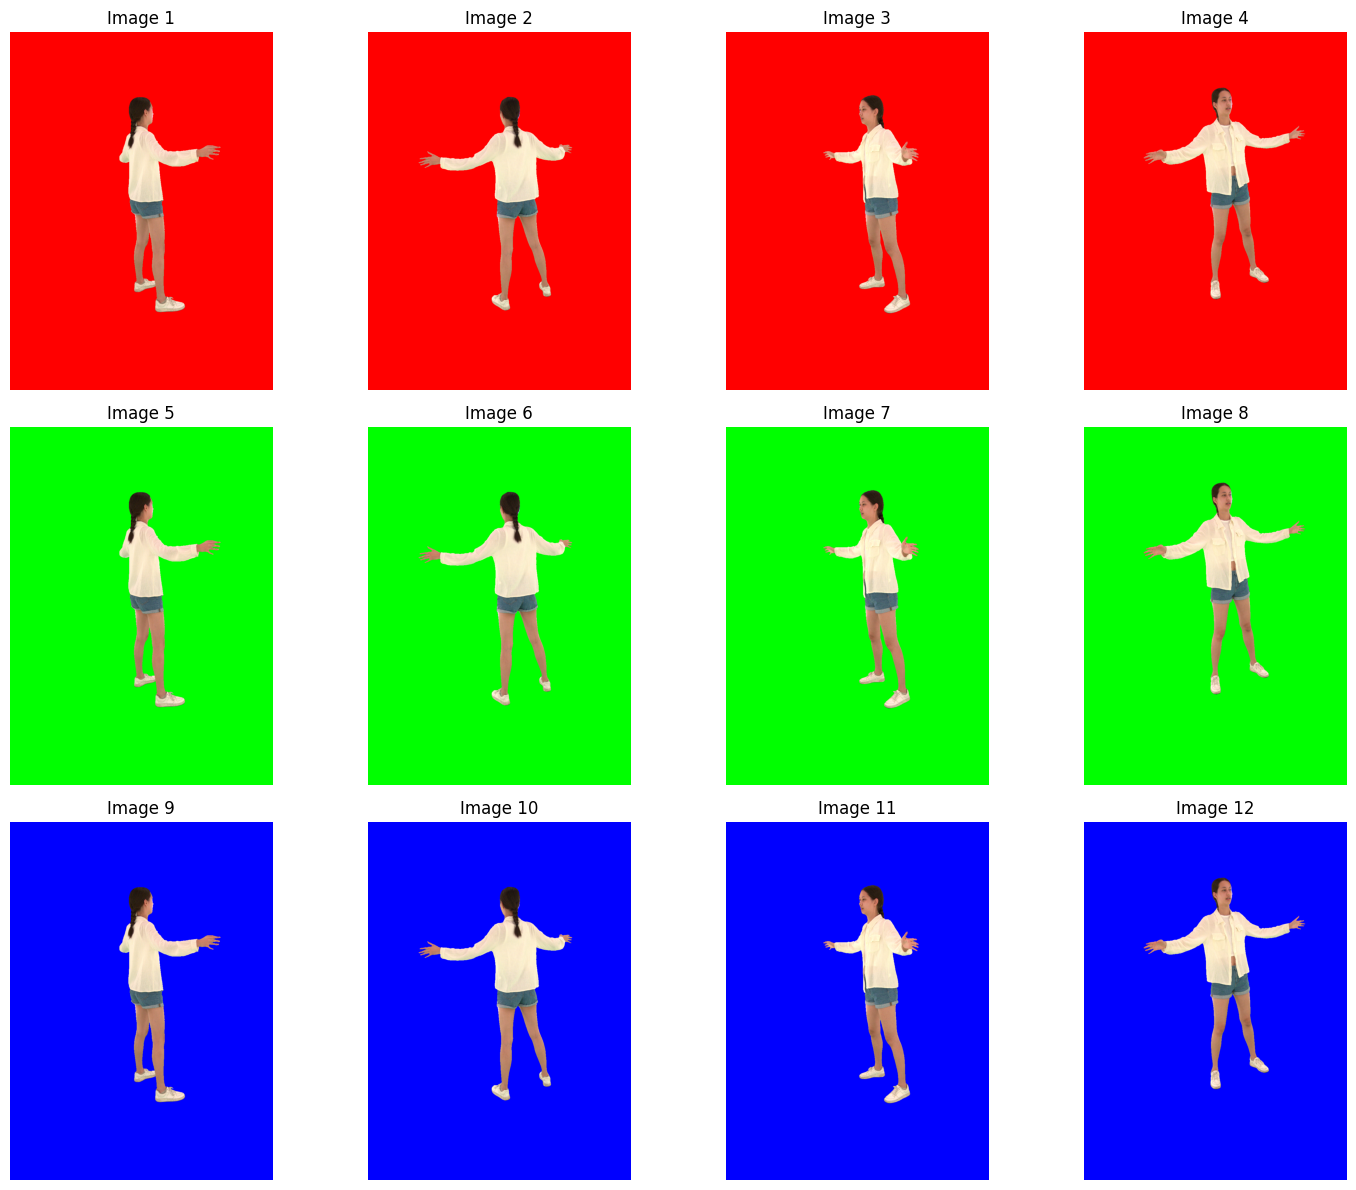

In [44]:
import matplotlib.pyplot as plt
import numpy as np

# 获取所有训练相机
train_cameras = scene.getTrainCameras()

# 创建3x4的子图画布
fig, axes = plt.subplots(3, 4, figsize=(15, 12))

# 遍历每个相机并绘制图像
for idx, cam in enumerate(train_cameras):
    # 转换图像格式
    gt_image = torch.from_numpy(cam.original_image).permute(2, 0, 1)  # 转为CHW
    img = gt_image.permute(1, 2, 0).numpy()  # 转回HWC
    img = (img * 255).astype(np.uint8)  # 确保转换为0-255的整型
    
    # 计算子图位置
    row = idx // 4
    col = idx % 4
    
    # 显示图像
    axes[row, col].imshow(img)
    axes[row, col].axis('off')  # 关闭坐标轴
    axes[row, col].set_title(f'Image {idx+1}')  # 可选：添加标题

plt.tight_layout()  # 自动调整子图间距
plt.show()

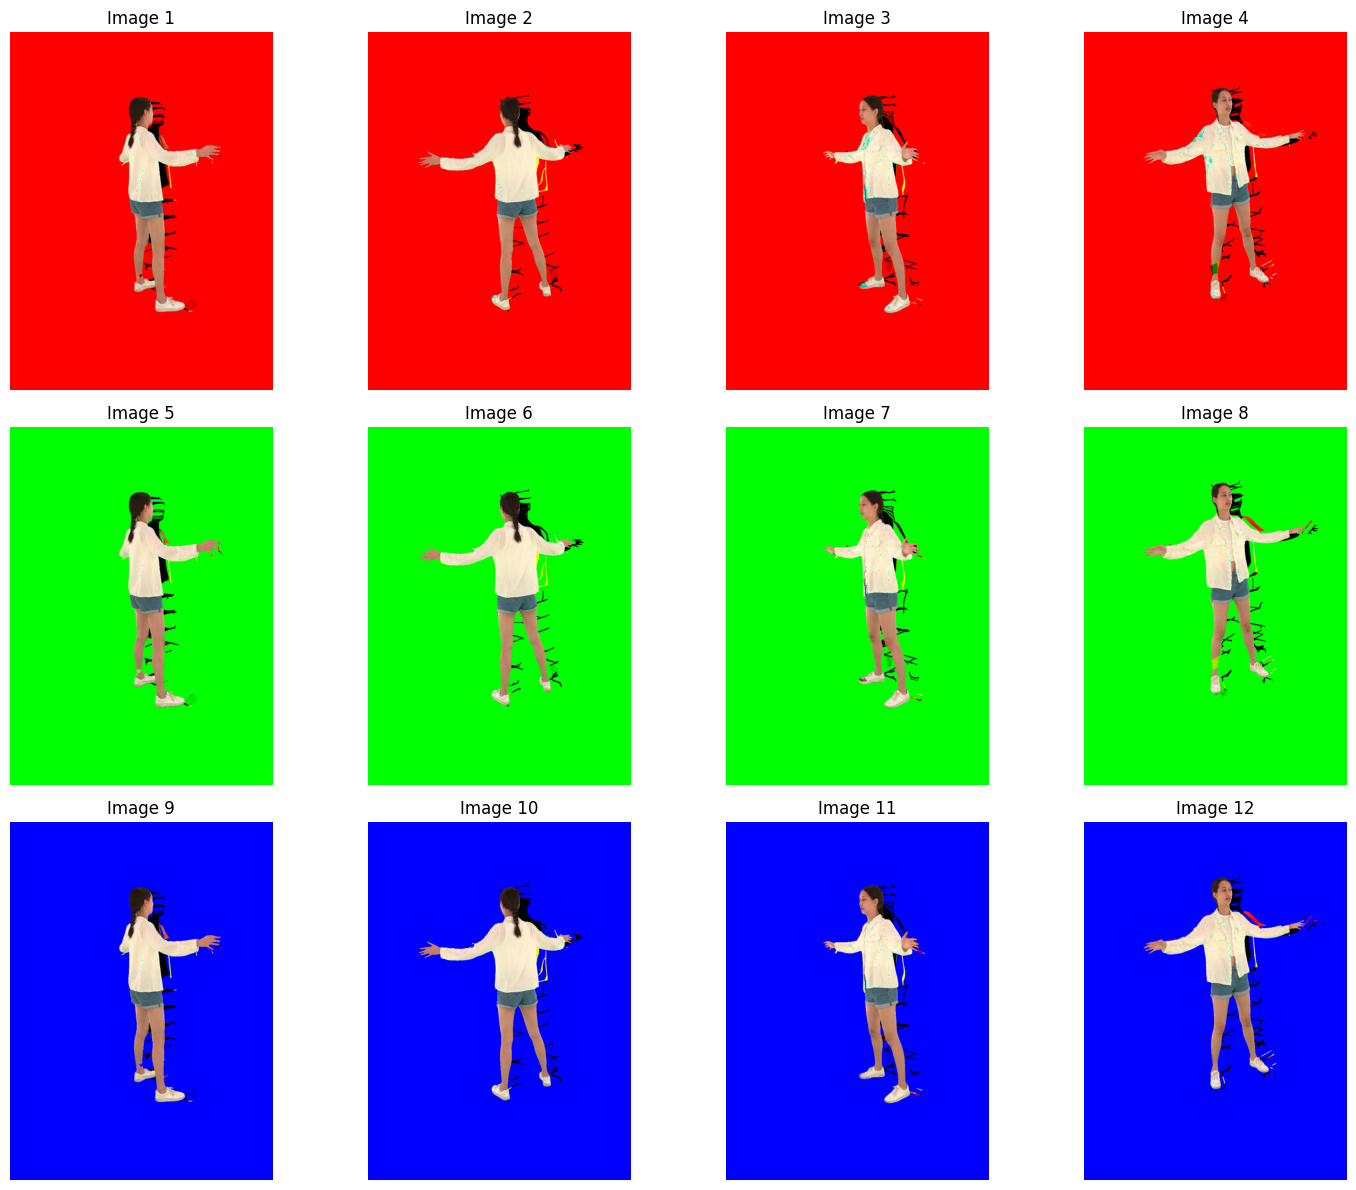

In [51]:
import matplotlib.pyplot as plt
import numpy as np

# 获取所有训练相机
train_cameras = scene.getTrainCameras()

# 创建3x4的子图画布
fig, axes = plt.subplots(3, 4, figsize=(15, 12))

# 遍历每个相机并绘制图像
for idx, cam in enumerate(train_cameras):
    # 转换图像格式
    bg_color = cam.bg
    background = torch.tensor(bg_color, dtype=torch.float32, device='cuda')
    render_pkg = render(cam, gaussians, args, background)
    image, viewspace_point_tensor, visibility_filter, radii = render_pkg["render"], render_pkg["viewspace_points"], render_pkg["visibility_filter"], render_pkg["radii"]
    image = image.permute(1,2,0).detach().cpu().numpy()  # 转为CHW
    img = (image * 255).astype(np.uint8)  # 确保转换为0-255的整型
    
    # 计算子图位置
    row = idx // 4
    col = idx % 4
    
    # 显示图像
    axes[row, col].imshow(img)
    axes[row, col].axis('off')  # 关闭坐标轴
    axes[row, col].set_title(f'Image {idx+1}')  # 可选：添加标题

plt.tight_layout()  # 自动调整子图间距
plt.show()

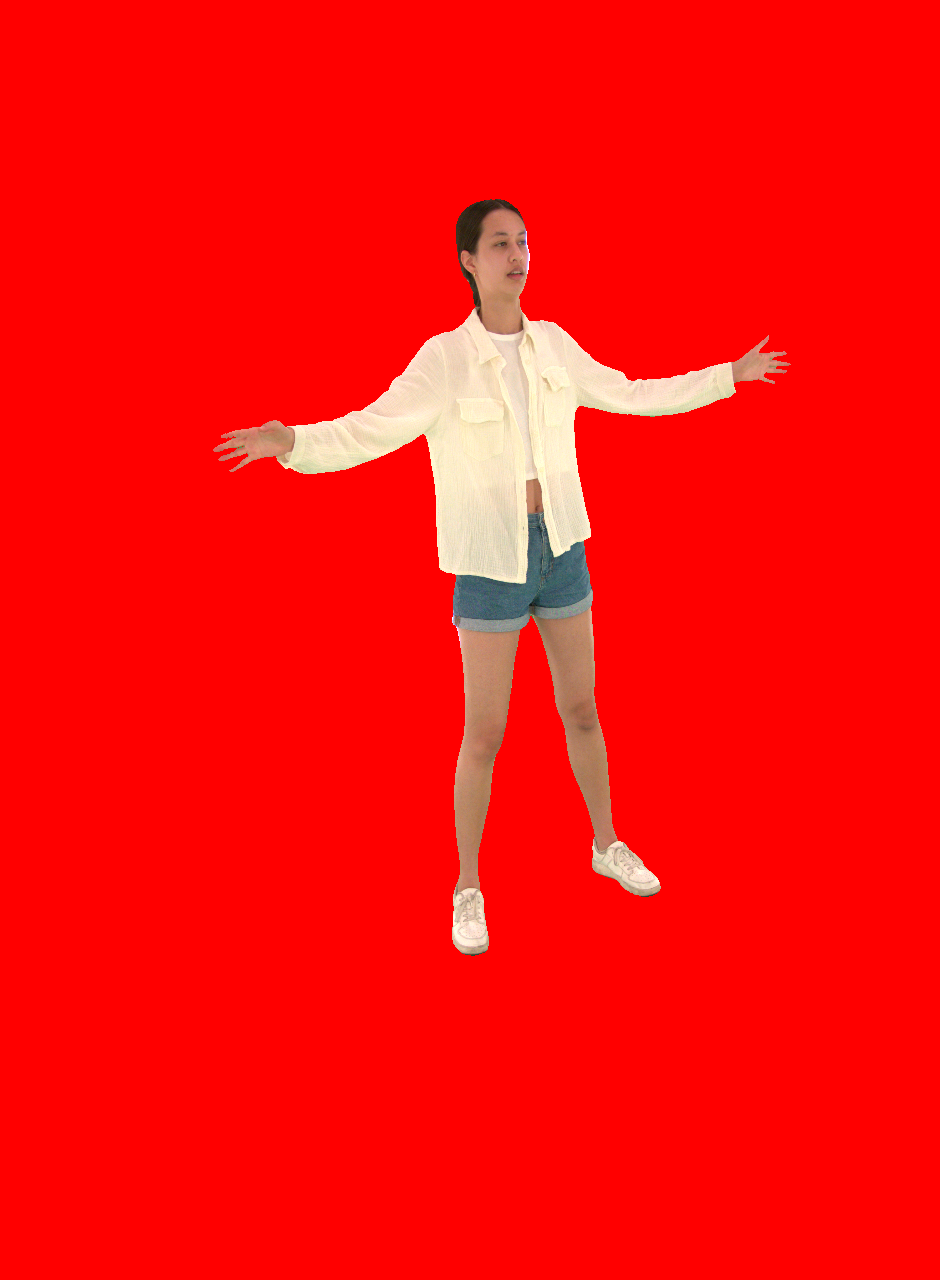

In [36]:
gt_image = torch.from_numpy(viewpoint_cam.original_image).permute(2, 0, 1).cuda()
img = gt_image.permute(1,2,0).detach().cpu().numpy()*255
img = img.astype(np.uint8)
img = Image.fromarray(img).convert('RGB')
img

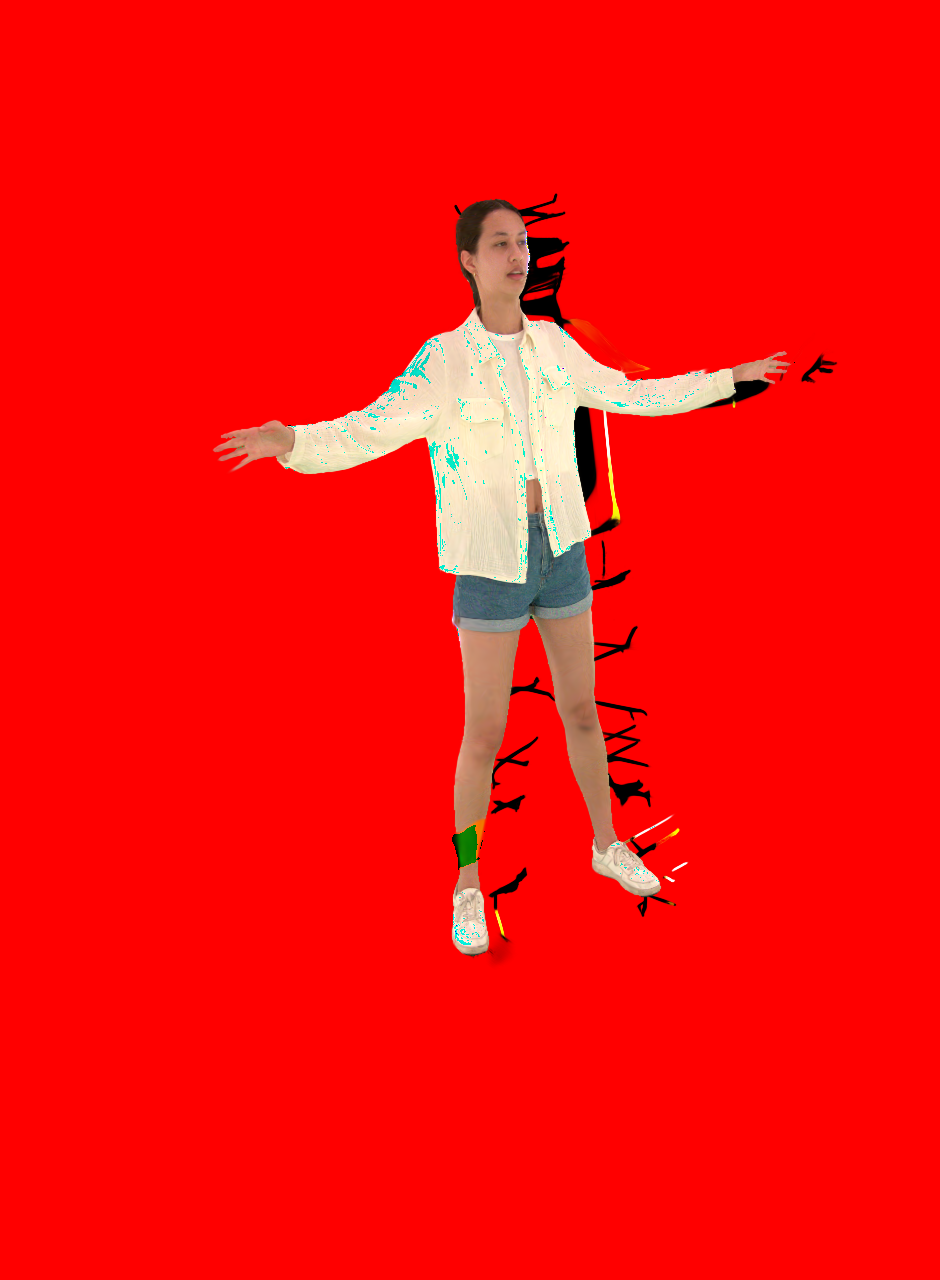

In [37]:
img = image.permute(1,2,0).detach().cpu().numpy()*255
img = img.astype(np.uint8)
img = Image.fromarray(img).convert('RGB')
img

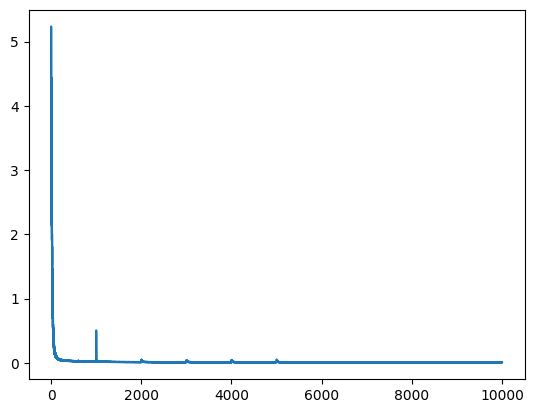

In [38]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots()
ax.plot(range(1, len(loss_history)+1), loss_history)
plt.show()

In [39]:
for i in range(len(gaussian_num)):
    if gaussian_num[i][0] < 300:
        print(i)
        break

In [40]:
gaussians.max_radii2D

tensor([18., 17., 18.,  ..., 35., 30., 50.], device='cuda:0')

In [41]:
50*gaussians.position_anchoring(0)

tensor(3.8322, device='cuda:0', dtype=torch.float64, grad_fn=<MulBackward0>)

In [42]:
gaussians.get_xyz

Parameter containing:
tensor([[ 0.0656,  1.4264, -0.0506],
        [ 0.0551,  1.4421, -0.0541],
        [ 0.0555,  1.4559, -0.0631],
        ...,
        [-0.1793,  1.8024,  0.2223],
        [-0.0125,  0.8292, -0.0293],
        [ 0.0836,  1.5434,  0.0062]], device='cuda:0', requires_grad=True)